In [5]:
import ppinetsim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

In [2]:
parameters = ppinetsim.Parameters('parameter_settings/params_1.json')

In [3]:
node_degrees_observed, num_ppis_observed, _, _ = ppinetsim.run_simulation(parameters, verbose=True)

In [14]:
node_degrees_observed_v, num_ppis_observed_v, _, _ = ppinetsim.run_simulation(parameters, verbose=True)

Text(0, 0.5, 'Frequency')

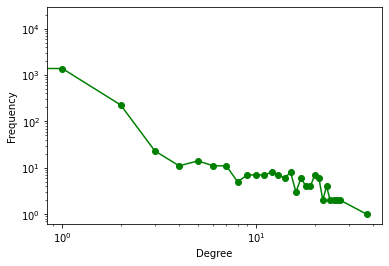

In [16]:
freqs_u = np.asarray(np.unique(node_degrees_observed, return_counts=True), dtype=float)
freqs_v = np.asarray(np.unique(node_degrees_observed_v, return_counts=True), dtype=float)
plt.loglog(freqs_u[0,],freqs_u[1,],'go-')
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [17]:
distr_u = ppinetsim.de

In [22]:


wasserstein_distance(freqs_u[0,], freqs_v[0,], freqs_u[1,], freqs_v[1,])

0.011700000000000044

In [23]:
l = [(9.3, 'd'), (3.3, 'e')]

In [24]:
l.sort()

In [25]:
l

[(3.3, 'e'), (9.3, 'd')]